## Naive Implementation

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt

def cluster(X, mu):
    clusters  = {}
    for x in X:
        best_mu = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[best_mu].append(x)
        except KeyError:
            clusters[best_mu] = [x]
    return clusters

def update(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu
 
def converged(mu, oldmu):
    # The algorith converge when the centroids stop moving 
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))
            
def Kmeans_imp(X, K):
    iterations= 0
    loss=[]
    # Initialize to K random centers
    oldmu = random.sample(X, K)
    mu = random.sample(X, K)
    while not converged(mu, oldmu):
        oldmu = mu
        # Assign all points in X to clusters
        clusters= cluster(X, mu)
        # Reevaluate centers
        mu = update(oldmu, clusters)
        iterations+=1
    return(mu, clusters, iterations,loss)
 

### Test 1 

In [10]:
from sklearn import datasets
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

In [11]:
%time

start_time=time.time()
k_means,clusters,it,loss = Kmeans_imp(X_iris,3)

print("--- %s seconds ---" % (time.time() - start_time))

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.2 µs
--- 0.0173420906067 seconds ---


In [12]:
%time
from sklearn.cluster import KMeans

start2=time.time()
k_means = KMeans(n_clusters=3)
k_means.fit(X_iris) 

print("--- %s seconds ---" % (time.time() - start2))


CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.01 µs
--- 0.0126678943634 seconds ---


### TEST 2 (Main test used in paper)

Example taken from:http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html

In [13]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs


In [14]:
# Generate sample data
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=10000, centers=centers, cluster_std=0.7)

### With initialization method k-means++

In [15]:
%time 
# Compute clustering with Means
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

print("--- %s seconds ---" %t_batch)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
--- 0.0970320701599 seconds ---


### Without it

In [16]:
%time 
# Compute clustering with Means
k_means = KMeans(n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

print("--- %s seconds ---" %t_batch)


CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 4.05 µs
--- 0.0741581916809 seconds ---


### Mini Batch Kmeans

In [147]:
%time
# Compute clustering with MiniBatchKMeans
mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0
mbk_means_labels = mbk.labels_
mbk_means_cluster_centers = mbk.cluster_centers_
mbk_means_labels_unique = np.unique(mbk_means_labels)

print("--- %s seconds ---" %t_mini_batch)


CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 5.96 µs
--- 0.0283050537109 seconds ---


### Plots 

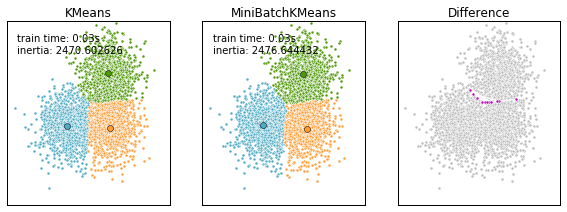

In [148]:
# Plot result

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.

order = pairwise_distances_argmin(k_means_cluster_centers,
                                  mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for l in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

### Comparison with naive implementation Results 

In [155]:
%time

start_time=time.time()
k_means,clusters,it,loss = Kmeans_imp(X,3)

print("--- %s seconds ---" % (time.time() - start_time))
k_means

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
--- 0.535263061523 seconds ---


[array([ 1.07705469, -1.06730994]),
 array([-1.07159013, -1.00648645]),
 array([ 0.96700708,  1.01837274])]

In [150]:
print k_means_labels
print k_means_cluster_centers 
 

[1 0 1 ..., 0 0 2]
[[-1.07262225 -1.00554224]
 [ 1.07510478 -1.06937206]
 [ 0.96786467  1.0173955 ]]


array([0, 1, 2], dtype=int32)